
                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.01      0.41      0.01     -0.68      0.68   2718.66      1.00

Number of divergences: 435


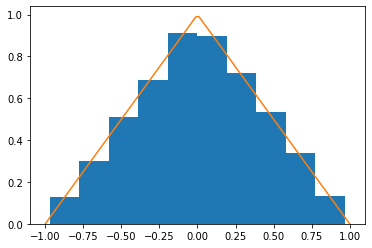

In [1]:
from functools import partial
import jax.numpy as np
from jax.random import PRNGKey
from jax.scipy.special import logsumexp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import numpy as onp

def f(x):
    return -np.log(np.clip(1 - np.abs(x), a_min=0.))

mcmc = MCMC(NUTS(potential_fn=f), num_warmup=100, num_samples=10000, progress_bar=False)
mcmc.run(PRNGKey(0), init_params=0.)
mcmc.print_summary()

plt.hist(mcmc.get_samples(), density=True)
x = np.linspace(-1, 1, 100)
plt.plot(x, np.exp(-f(x)));

In [2]:
def dequantized_binomial(x, total_count=20, probs=0.7):
    base_dist = dist.Binomial(total_count, probs)
    lb = np.floor(x)
    ub = lb + 1
    quantized = np.stack([lb, ub])
    log_prob = base_dist.log_prob(quantized)
    log_prob = np.where(quantized == 0, log_prob + np.log(2), log_prob)
    log_prob = np.where(base_dist.support(quantized), log_prob, -np.inf)
    logits = np.log(np.stack([ub - x, x - lb]))
    o = logsumexp(log_prob + logits, axis=0)
    return -o

In [3]:
total_count = 100
fn = partial(dequantized_binomial, total_count=total_count)
mcmc = MCMC(NUTS(potential_fn=fn),
            num_warmup=100, num_samples=10000, progress_bar=False)
mcmc.run(PRNGKey(0), init_params=0.1)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0     70.09      4.56     70.18     62.80     77.98   3339.39      1.00

Number of divergences: 0


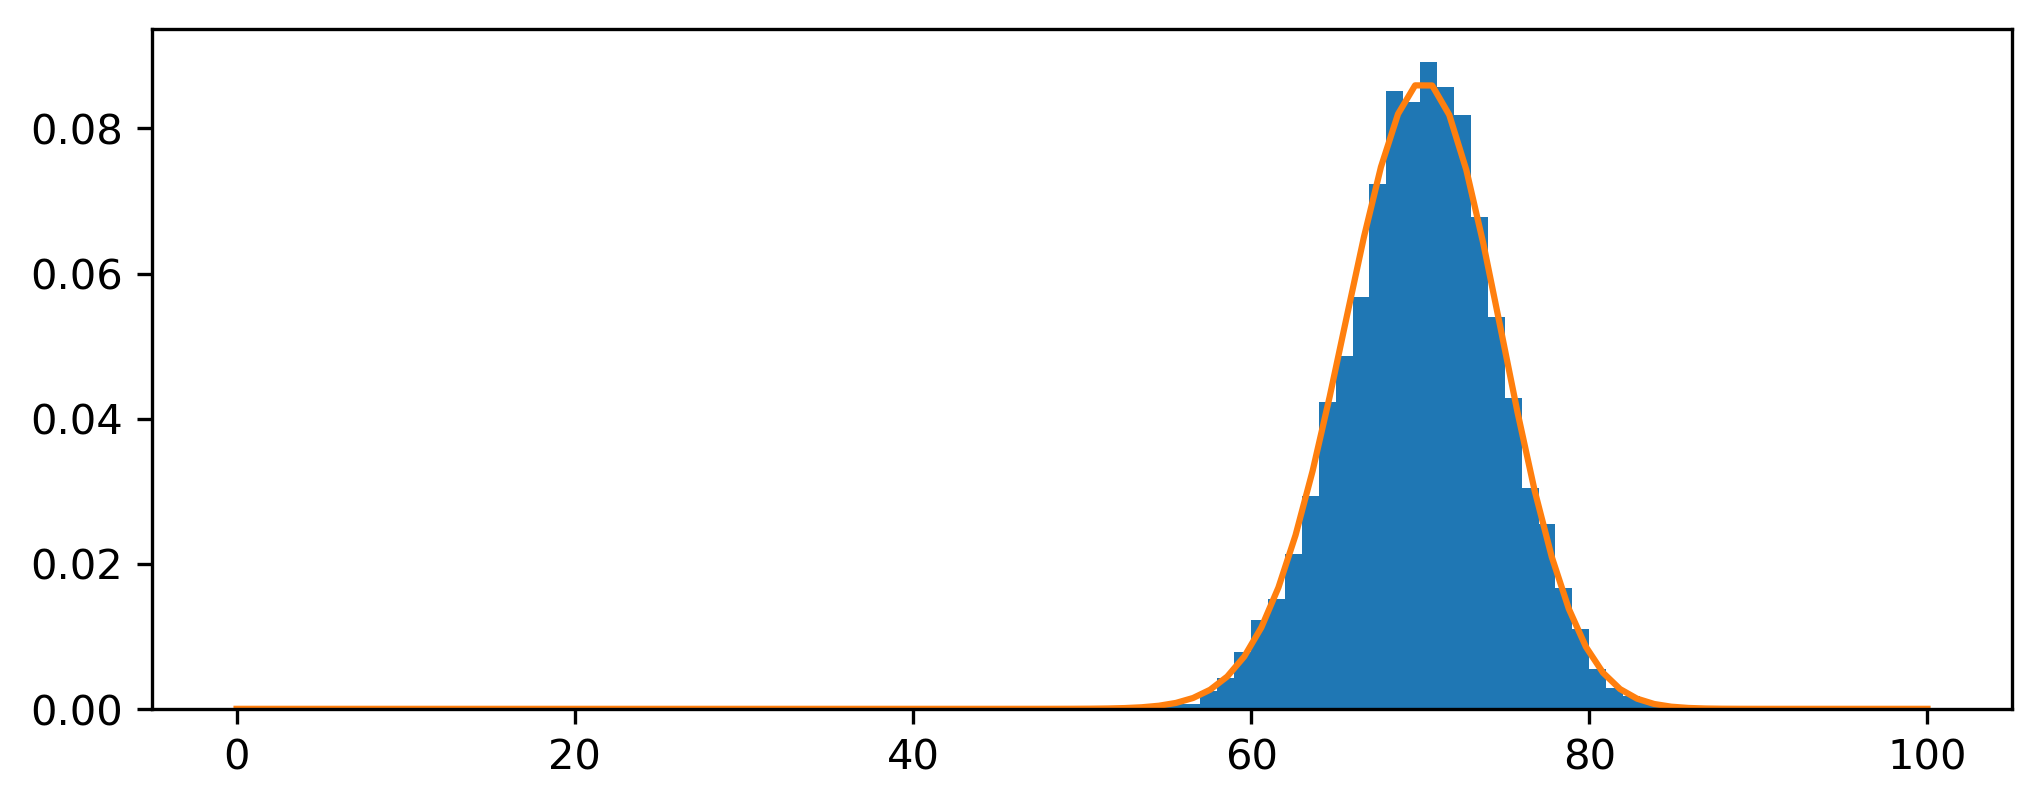

In [4]:
plt.figure(figsize=(8, 3), dpi=300).patch.set_color('white')
plt.hist(mcmc.get_samples(), density=True, bins=range(0, total_count))
x = np.linspace(0, total_count, 100)
plt.plot(x, np.exp(-fn(x)));